<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/DengAI_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DengAI: predecir la propagación de enfermedades**

> ***Jesús Roque Armas Martín***

---

Se utilizarán los datos del desafío DengAI, de la competición de [DrivenData](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

El objetivo del ejercicio es participar en una competición de Inteligencia Artificial aplicada a Big data.

El desafío consiste en predecir el número de casos de dengue en un intervalo temporal semanal en dos poblaciones de Centroamérica: San Juan, Puerto Rico e Iquitos, Perú, usando datos ambientales recopilados por agencias del gobierno federal de los EE. UU.

---



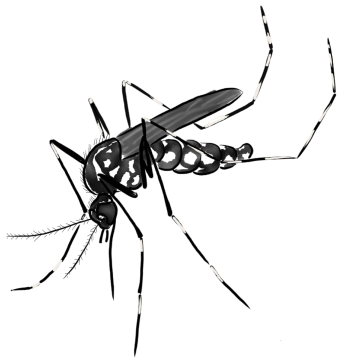
[licencia de la imagen](https://pixabay.com/es/service/license-summary/)

In [100]:
# Imports de librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor

***Importación de datos desde GitHub***

Además de traer los datos, importo el formato de subida, para después rellenarlo.

Fusiono los datasets de x e y, para tenerlos en un solo objeto dataframe y simplificar las operaciones futuras.


In [167]:
miGitHub="https://raw.githubusercontent.com/roquearmas/datasets/main/"
X_train = pd.read_csv(miGitHub + 'dengue_features_train.csv')
y_train = pd.read_csv(miGitHub + 'dengue_labels_train.csv')
X_test = pd.read_csv(miGitHub + 'dengue_features_test.csv')
sub_format = pd.read_csv(miGitHub + 'submission_format.csv')
df_train = pd.merge(X_train,y_train,on=['city', 'year', 'weekofyear'])
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Información detallada del dataset

In [168]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

La columna week_start_date, que representa la fecha del estudio, no nos interesa. No es una característica relevante para el ejercicio, ya que tenemos la semana del año y el año. Es información redundante.

In [169]:
df_train.drop("week_start_date", axis = 1, inplace = True)
X_test.drop("week_start_date", axis = 1, inplace = True)
df_train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Buscamos los elementos nulos en el dataset de entrenamiento.


In [5]:
pd.isnull(df_train).sum()

city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_pr

Para no perder calidad en el dato, voy a "extender" la última observación obtenida, antes de los valores nulos, a los revgistros con valores nulos
https://pandas.pydata.org/docs/reference/api/pandas.api.extensions.ExtensionArray.fillna.html

In [170]:
df_train.fillna(method='ffill', inplace=True)
pd.isnull(df_train).sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases

Lo mismo con el dataset de test

In [171]:
X_test.fillna(method='ffill', inplace=True)
pd.isnull(X_test).sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

Lo siguiente es transformar las variables categóricas. En el caso que nos ocupa, las ciudades. Utilizo un binarizador, para que asigne un número a una ciudad y otro número a la otra:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [172]:
lb = preprocessing.LabelBinarizer()
df_train['city'] = lb.fit_transform(df_train['city'])
y_train['city'] = lb.fit_transform(y_train['city'])
X_test['city'] = lb.fit_transform(X_test['city'])

1 - sj - San Jose

2 - iq - Iquitos

In [173]:
df_train.tail()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1451,0,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,0,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,...,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,0,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,0,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,...,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1
1455,0,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,...,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4


***Escalado de valores***

Utilizo MinMaxScaler para que los valores de todas las características estén concentrados en el rango entre 0 y 1, exceptuando el año y la semana del año, porque me daban problemas a la hora de exportar los resultados.

In [176]:
scaler = MinMaxScaler()
datos_escalados =df_train.copy()
#no quiero que escale la columna de la y (total_cases), para mantenerla con su valor inicial, para que sean más sencillas las predicciones finales
datos_escalados =scaler.fit_transform(datos_escalados.drop('total_cases', axis=1))
nombres_columnas=df_train.columns
nombres_columnas = list(nombres_columnas)
#elimino el bombre de columna 'total_cases' porque el dataset escalado no lo tiene
del nombres_columnas[23]

X_train_escalado = pd.DataFrame(datos_escalados, columns=nombres_columnas)
X_train_escalado['year']=df_train['year']
X_train_escalado['weekofyear']=df_train['weekofyear']
#añado la columna 'total_cases' del dataset original, con sus valores originales
X_train_escalado['total_cases'] = df_train['total_cases']


X_test_escalado=scaler.transform(X_test)
X_test_escalado = pd.DataFrame(X_test_escalado, columns=X_test.columns)
X_test_escalado['year']=X_test['year']
X_test_escalado['weekofyear']=X_test['weekofyear']
X_test

# Se observa que el dato de la ciudad, categorizado como 0 y 1, se ha escalado correctamente (0. y 1., respectivamente)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,1,2008,20,-0.001500,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,1,2008,21,-0.001500,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,1,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,0,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,0,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,0,2013,25,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,...,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1


Se detectan valores negativos. Reemplazo esos valores por su valor absoluto, puesto que son todo magnitudes físicas que no tienen posibilidad de ser negativas, al menos, en Centroamérica.

In [177]:
X_train_escalado = X_train_escalado.applymap(lambda x: abs(x))
X_train_escalado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   float64
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   ndvi_ne                                1456 non-null   float64
 4   ndvi_nw                                1456 non-null   float64
 5   ndvi_se                                1456 non-null   float64
 6   ndvi_sw                                1456 non-null   float64
 7   precipitation_amt_mm                   1456 non-null   float64
 8   reanalysis_air_temp_k                  1456 non-null   float64
 9   reanalysis_avg_temp_k                  1456 non-null   float64
 10  reanalysis_dew_point_temp_k            1456 non-null   float64
 11  rean

In [148]:
#Exporto los datos a CSV para compararlos
X_train_escalado.to_csv('Datos_Escalados.csv',index=False)
df_train.to_csv('Datos_sin_escalar.csv')


Ya tenemos el dataset preparado para determinar las características más relevantes y empezar a entrenar los modelos.

***Selección de características más relevantes***

Comienzo con la matriz de correlación, representándola con un mapa de calor, que nos ayuda a detectar, a simple vista, las características correlacionadas

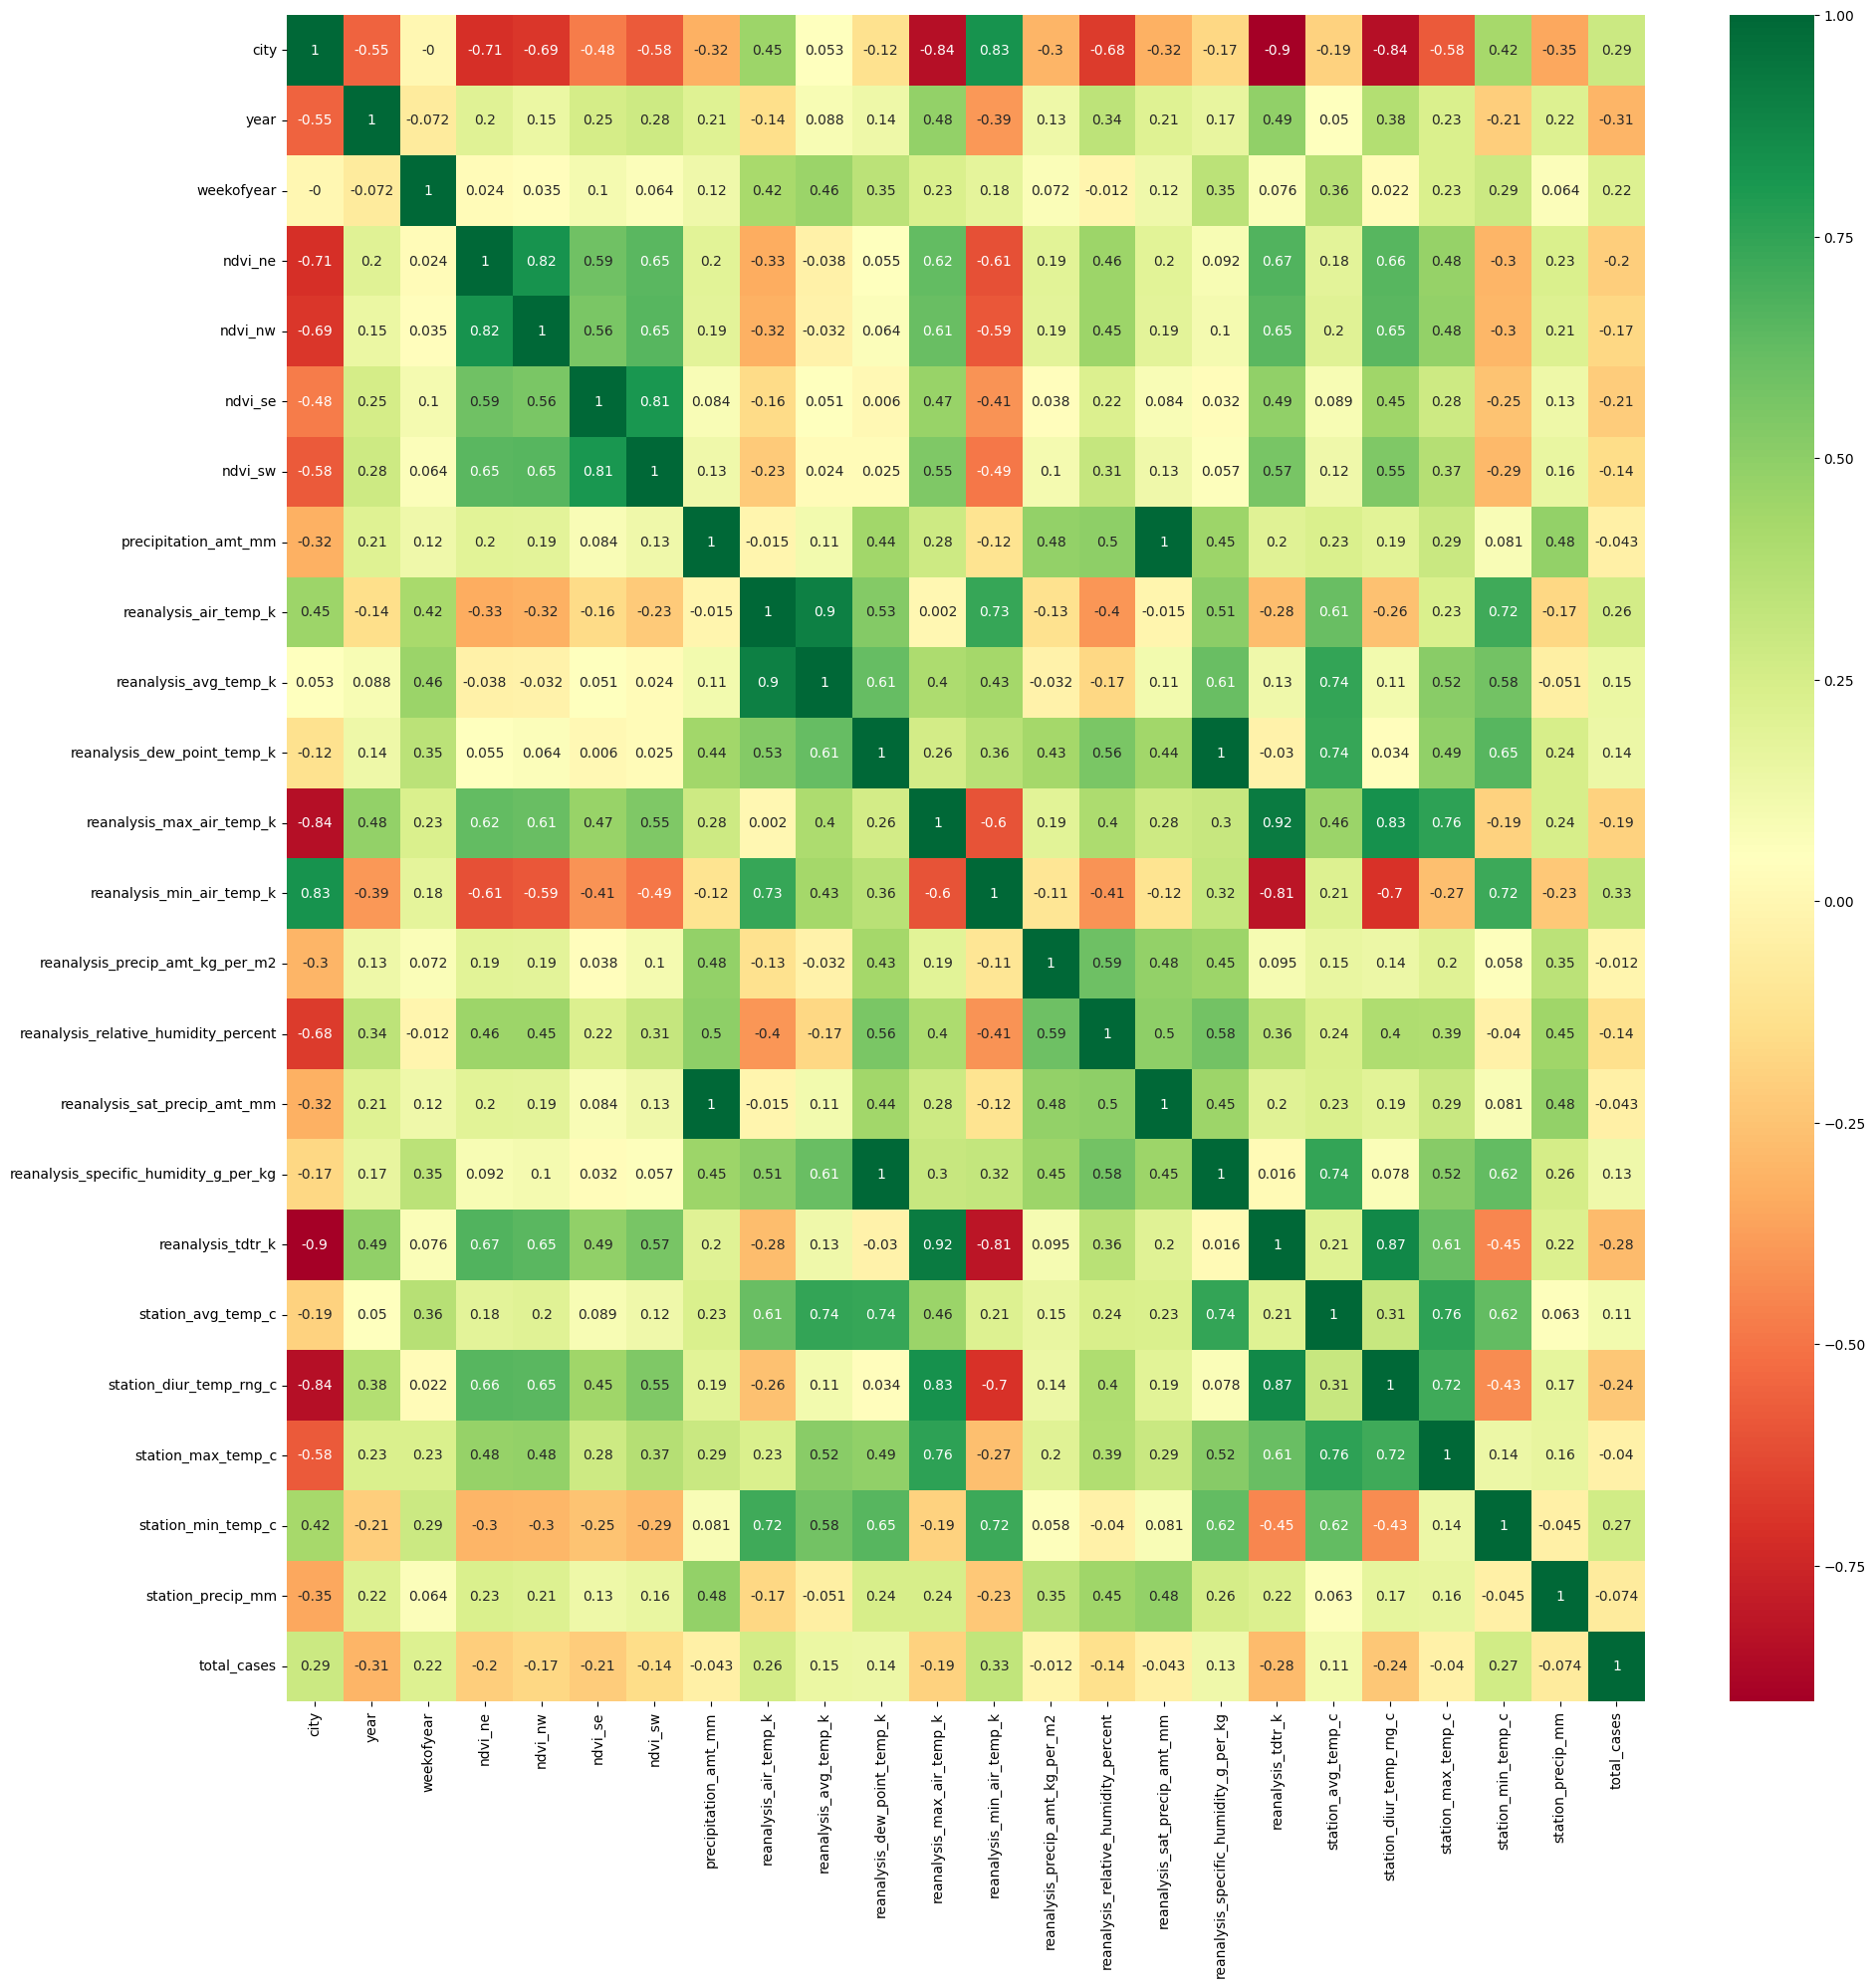

In [14]:
sns.heatmap(X_train_escalado.corr().round(3),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(22,22) # tamaño de la visualización
plt.show()

Se observa que, a pesar de estar penúltima en el índice de columnas del dataframe, la matriz de correlación, ha colocado la columna de las etiquetas (y, en nuestro caso 'total_cases'), al final, abajo y a la derecha.

Por lo tanto, la columna de las etiquetas no tiene que estar necesariamente a la derecha en el DataFrame para calcular la matriz de correlación. Se Puede colocar la columna de las etiquetas en cualquier posición en el DataFrame y el cálculo de la matriz de correlación se realizará correctamente entre las variables numéricas.

Según lo que representa la matriz de correlación, se podría prescindir de varias columnas.

In [153]:
selector = SelectKBest(score_func=f_regression, k=6)
X_train_sin_casos_totales =X_train_escalado.drop('total_cases', axis=1)
X_mejores_caracteristicas = selector.fit_transform(X_train_sin_casos_totales, X_train_escalado['total_cases'] )
indices_caracteristicas_seleccionadas = selector.get_support(indices=True)

print("Índices de las características seleccionadas:", indices_caracteristicas_seleccionadas)
scores = selector.scores_
lista_columnas=list(X_train_escalado.columns)
for i, puntaje in enumerate(scores):
    print(f"Carac. {i}:\t {puntaje:.2f}\t {lista_columnas[i]}")


Índices de las características seleccionadas: [ 0  1  8 12 17 21]
Carac. 0:	 136.16	 city
Carac. 1:	 151.09	 year
Carac. 2:	 71.47	 weekofyear
Carac. 3:	 63.85	 ndvi_ne
Carac. 4:	 42.43	 ndvi_nw
Carac. 5:	 69.37	 ndvi_se
Carac. 6:	 31.35	 ndvi_sw
Carac. 7:	 2.66	 precipitation_amt_mm
Carac. 8:	 108.48	 reanalysis_air_temp_k
Carac. 9:	 33.14	 reanalysis_avg_temp_k
Carac. 10:	 28.66	 reanalysis_dew_point_temp_k
Carac. 11:	 56.12	 reanalysis_max_air_temp_k
Carac. 12:	 172.11	 reanalysis_min_air_temp_k
Carac. 13:	 0.19	 reanalysis_precip_amt_kg_per_m2
Carac. 14:	 26.92	 reanalysis_relative_humidity_percent
Carac. 15:	 2.66	 reanalysis_sat_precip_amt_mm
Carac. 16:	 23.57	 reanalysis_specific_humidity_g_per_kg
Carac. 17:	 123.23	 reanalysis_tdtr_k
Carac. 18:	 19.16	 station_avg_temp_c
Carac. 19:	 86.64	 station_diur_temp_rng_c
Carac. 20:	 2.34	 station_max_temp_c
Carac. 21:	 109.57	 station_min_temp_c
Carac. 22:	 8.01	 station_precip_mm


Por lop tanto, las columnas elegidas, son las que pasan de 100 en la valoración de selectKbest: *year*, *reanalysis_air_temp_k*, *reanalysis_min_air_temp_k*, *reanalysis_tdtr_k*, *station_min_temp_c* y *city*.

Por una apreciación personal, me parece importante la columna 2, *week of year*, y como hay una columna (*station_diur_temp_rng_c*) con mayor puntuación, siendo menor que 100, también la incluiré.

Por lo tanto, dejaré en total, 8 columnas y eliminaré las demás.

In [178]:
#elimino columnas para dejar el X_train definitivo
X_train_definitivo = X_train_escalado.drop(['ndvi_ne','ndvi_nw', 'ndvi_se','ndvi_sw'
                          ,'precipitation_amt_mm', 'reanalysis_avg_temp_k','reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k'
                          ,'reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent'
                          ,'reanalysis_sat_precip_amt_mm','reanalysis_specific_humidity_g_per_kg'
                          ,'station_avg_temp_c','station_max_temp_c','station_precip_mm', 'total_cases'], axis=1)
X_test_definitivo =X_test.drop(['ndvi_ne','ndvi_nw', 'ndvi_se','ndvi_sw'
                          ,'precipitation_amt_mm', 'reanalysis_avg_temp_k','reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k'
                          ,'reanalysis_precip_amt_kg_per_m2','reanalysis_relative_humidity_percent'
                          ,'reanalysis_sat_precip_amt_mm','reanalysis_specific_humidity_g_per_kg'
                          ,'station_avg_temp_c','station_max_temp_c','station_precip_mm'], axis=1)
X_train_definitivo

,city,year,weekofyear,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c
0,1.0,1990,18,0.388291,0.692308,0.086660,0.210393,0.486239
1,1.0,1990,19,0.472710,0.730769,0.069133,0.163498,0.688073
2,1.0,1990,20,0.548064,0.800000,0.064265,0.173638,0.743119
3,1.0,1990,21,0.575260,0.776923,0.073028,0.198986,0.788991
4,1.0,1990,22,0.645515,0.815385,0.112950,0.429658,0.844037
...,...,...,...,...,...,...,...,...
1451,0.0,2010,21,0.621152,0.584615,0.575463,0.656950,0.706422
1452,0.0,2010,22,0.488385,0.384615,0.416748,0.529785,0.642202
1453,0.0,2010,23,0.259490,0.423077,0.418695,0.210393,0.412844
1454,0.0,2010,24,0.226062,0.384615,0.444012,0.373046,0.577982


***Entrenamiento de modelos***

In [180]:
#Comienzo con el modelo básico LinearRegression(), para obtener los resultados de partida
model = linear_model.LinearRegression()
model.fit(X_train_definitivo, y_train)

LinearRegression()

In [179]:
X_test_definitivo

,city,year,weekofyear,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c
0,1,2008,18,298.492857,296.4,3.128571,7.057143,21.7
1,1,2008,19,298.475714,296.7,2.571429,5.557143,22.2
2,1,2008,20,299.455714,296.4,4.428571,7.785714,22.8
3,1,2008,21,299.690000,296.9,4.342857,6.271429,24.4
4,1,2008,22,299.780000,297.3,3.542857,7.085714,23.3
...,...,...,...,...,...,...,...,...
411,0,2013,22,297.774286,292.7,10.100000,9.050000,21.8
412,0,2013,23,297.167143,291.6,9.657143,10.720000,21.4
413,0,2013,24,295.831429,290.7,7.385714,10.075000,21.6
414,0,2013,25,295.778571,292.5,8.228571,8.480000,21.8


In [181]:
y_pred = model.predict(X_test_definitivo)
#redondeo los resultados
y=np.rint(y_pred) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

y

array([[   1, 2008,   18, 9002],
       [   1, 2008,   19, 9033],
       [   1, 2008,   20, 8972],
       ...,
       [   0, 2013,   24, 8728],
       [   0, 2013,   25, 8637],
       [   0, 2013,   26, 8583]])

***Exportación de resultados***

In [42]:
nombre_fichero='Linear_Regression_RAM'

salida=pd.DataFrame(y,columns=sub_format.columns)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Linear Regression***

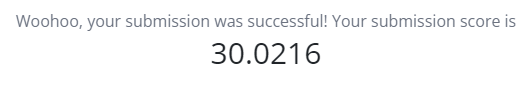

Como no hay y de test, utilizo datos de validación, para poder sacar las métricas de error.

In [19]:
X_train_div, X_valid, y_train_div, y_valid = train_test_split(X_train_definitivo, y_train, test_size=0.2)

In [ ]:
y_valid


,city,year,weekofyear,total_cases
1259,0,2006,37,3
511,1,2000,8,4
387,1,1997,41,52
1346,0,2008,21,2
1289,0,2007,16,5
...,...,...,...,...
576,1,2001,22,5
682,1,2003,24,13
807,1,2005,44,46
165,1,1993,26,21


In [20]:
MAPE_minimo=2
for k in range(1,101):
  w = "uniform"
  regr = KNeighborsRegressor(k, weights=w)
  # entrenamiento con los datos
  regr.fit(X_train_div, y_train_div)
  # 4. predicción con nuevos datos
  y_pred = regr.predict(X_valid)
  MAPE_Actual =mean_absolute_percentage_error(y_pred, y_valid)
  if MAPE_Actual < MAPE_minimo:
    MAPE_minimo=MAPE_Actual

print ('MAPE minimo con %i vecinos, %2f' %(k,MAPE_minimo))

MAPE minimo con 100 vecinos, 0.183056


In [21]:
# X_train_definitivo
X_valid

,city,year,weekofyear,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c
419,1.0,0.40,0.384615,0.712370,0.838462,0.100292,0.216730,0.788991
318,1.0,0.30,0.442308,0.542965,0.815385,0.045764,0.129278,0.788991
625,1.0,0.60,0.346154,0.572238,0.792308,0.077897,0.131812,0.743119
85,1.0,0.05,0.961538,0.455902,0.746154,0.048685,0.144487,0.541284
334,1.0,0.30,0.750000,0.711615,0.900000,0.050633,0.120406,0.844037
...,...,...,...,...,...,...,...,...
137,1.0,0.10,0.961538,0.482531,0.730769,0.087634,0.342205,0.642202
817,1.0,0.80,0.019231,0.488763,0.746154,0.074002,0.201521,0.385321
820,1.0,0.80,0.076923,0.384136,0.661538,0.054528,0.140684,0.385321
496,1.0,0.45,0.846154,0.617186,0.853846,0.046738,0.117871,0.844037


*KNN Con Cross Validation*

In [22]:
#Divide los datos en n_splits partes, de manera aleatoria (shuffle)
cv = KFold(n_splits = 100, shuffle = False) #al poner shuffle =True desordenaba el dataset
cv_mape=[]
for i in range(2,20):
  for cv_train, cv_test in cv.split(X_train_definitivo):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_definitivo.iloc[cv_train]
    cv_train_y = y_train.iloc[cv_train]

    # vamos entrenando los modelos
    regr.fit(cv_train_x, cv_train_y)

    #guardo el predict de cada modelo
    y_pred = regr.predict(X_train_definitivo.iloc[cv_test])
    #y_np=np.zeros(len(cv_test))
    y_np=y_train.iloc[cv_test].values

    mape = mean_absolute_percentage_error(  y_pred,y_np)

    cv_mape.append(mape)
  #guardo la media de los mapes, para cada split
  media_mape=sum(cv_mape)/len(cv_mape)

  #recorro los clasificadores y voy mostrando la precision por cada uno de ellos
  print ("MAPE medio: = %.4f para %i splits" %  (media_mape,i ))

MAPE medio: = 0.2339 para 2 splits
MAPE medio: = 0.2339 para 3 splits
MAPE medio: = 0.2339 para 4 splits
MAPE medio: = 0.2339 para 5 splits
MAPE medio: = 0.2339 para 6 splits
MAPE medio: = 0.2339 para 7 splits
MAPE medio: = 0.2339 para 8 splits
MAPE medio: = 0.2339 para 9 splits
MAPE medio: = 0.2339 para 10 splits
MAPE medio: = 0.2339 para 11 splits
MAPE medio: = 0.2339 para 12 splits
MAPE medio: = 0.2339 para 13 splits
MAPE medio: = 0.2339 para 14 splits
MAPE medio: = 0.2339 para 15 splits
MAPE medio: = 0.2339 para 16 splits
MAPE medio: = 0.2339 para 17 splits
MAPE medio: = 0.2339 para 18 splits
MAPE medio: = 0.2339 para 19 splits


In [182]:

  # regr = KNeighborsRegressor(100, weights="distance")
  regr = KNeighborsRegressor(100, weights="uniform")
  # entrenamiento con los datos
  regr.fit(X_train_definitivo, y_train)
  # predicción con nuevos datos
  y_pred = regr.predict(X_valid)
  MAPE_Actual =mean_absolute_percentage_error(y_pred, y_valid)
  print ('MAPE con 100 vecinos, %2f' %(MAPE_Actual))

MAPE con 100 vecinos, 0.404952


In [24]:
X_valid

,city,year,weekofyear,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c
419,1.0,0.40,0.384615,0.712370,0.838462,0.100292,0.216730,0.788991
318,1.0,0.30,0.442308,0.542965,0.815385,0.045764,0.129278,0.788991
625,1.0,0.60,0.346154,0.572238,0.792308,0.077897,0.131812,0.743119
85,1.0,0.05,0.961538,0.455902,0.746154,0.048685,0.144487,0.541284
334,1.0,0.30,0.750000,0.711615,0.900000,0.050633,0.120406,0.844037
...,...,...,...,...,...,...,...,...
137,1.0,0.10,0.961538,0.482531,0.730769,0.087634,0.342205,0.642202
817,1.0,0.80,0.019231,0.488763,0.746154,0.074002,0.201521,0.385321
820,1.0,0.80,0.076923,0.384136,0.661538,0.054528,0.140684,0.385321
496,1.0,0.45,0.846154,0.617186,0.853846,0.046738,0.117871,0.844037


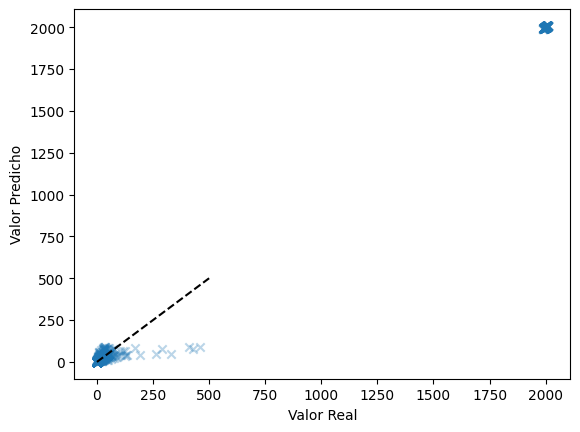

In [158]:
# Gráfica de dispersión entre los valores reales de la variable dependiente y los valores predichos

plt.scatter(y_valid, y_pred , alpha = 0.3, marker = 'x')
plt.plot([0, 500], [0, 500], "--k")
plt.axis("tight")
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.show()

In [197]:
regr.fit(X_train_definitivo, y_train)
y_pred_def = regr.predict(X_test_definitivo)
X_resultado =X_test.copy()
#X_resultado.drop(['total_cases'], axis=1)
print(type(X_resultado))
print(type(y_pred_def))
salida=pd.DataFrame(y_pred_def,columns=sub_format.columns,index=None)
X_resultado['total_cases'] = salida['total_cases']

#redondeo los resultados
y=np.rint(X_resultado) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
     city  year  weekofyear  total_cases
0       1  2008          18           23
1       1  2008          19           24
2       1  2008          20           25
3       1  2008          21           25
4       1  2008          22           28
..    ...   ...         ...          ...
411     0  2013          22           27
412     0  2013          23           29
413     0  2013          24           30
414     0  2013          25           31
415     0  2013          26           31

[416 rows x 4 columns]


MAPE: 40.50%


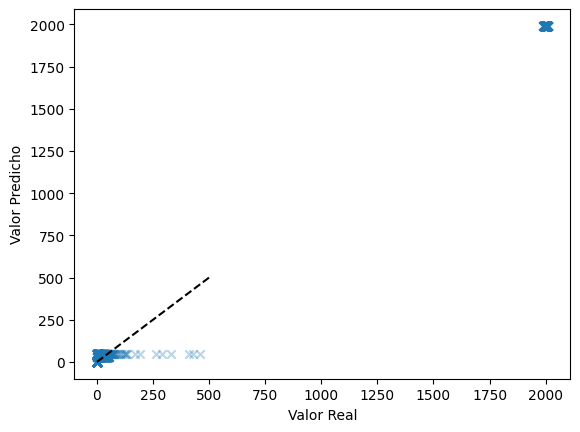

In [199]:
valida(regr)

In [200]:
nombre_fichero='KNN_Regressor_RAM'

salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
# #salida=salida.drop(salida.columns[0],axis=1)
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

     city  year  weekofyear  total_cases
0       1  2008          18           23
1       1  2008          19           24
2       1  2008          20           25
3       1  2008          21           25
4       1  2008          22           28
..    ...   ...         ...          ...
411     0  2013          22           27
412     0  2013          23           29
413     0  2013          24           30
414     0  2013          25           31
415     0  2013          26           31

[416 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Resultado** de subida de ***KNN Regressor***


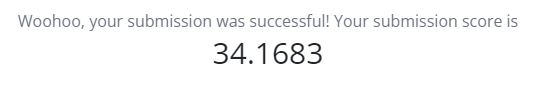

***Entrenamiento de árboles***



In [74]:
def cv_modelo (modelo,s):
  cv = KFold(n_splits=s, shuffle = False)
  cv_mape=[]

  X_train_np= np.array(X_train_definitivo)
  y_train_np= np.array(y_train['total_cases'])
  for cv_train, cv_test in cv.split(X_train_np, y_train_np):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_np[cv_train]
    cv_train_y = y_train_np[cv_train]
    #     cv_train_y= cv_train_y.apply(lambda x: x - 3)
    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    #guardo el predict de cada modelo
    y_test = y_train['total_cases'].iloc[cv_test].values
    y_pred = modelo.predict(X_train_np[cv_test])
    # mape= mean_absolute_percentage_error(y_test,y_pred)
    mape= mean_absolute_percentage_error(y_pred,y_test)
    cv_mape.append(mape)

  # Calculo el MAPE y loa devuelvo
  mape_medio=sum(cv_mape)/len(cv_mape)
  return mape_medio

In [86]:
def calcular_splits(modelo, inicio, fin):
  mape_min=float('inf') # infinito
  mape=101
  split_dec=0
  for i in range(inicio,fin,1):
    mape=cv_modelo (modelo,i)
    # print ("Modelo %s MAPE: = %.4f para %d splits" %  (modelo,mape,i))
    if mape<mape_min:
      split_dec=i
      mape_min=mape

  print ("Modelo %s MAPE mínimo: = %.4f para %d splits" %  (modelo,mape_min,split_dec ))

In [87]:
%%time
# DecisionTreeClassifier
calcular_splits(DecisionTreeRegressor(),3,11)

# RandomForestClassifier
calcular_splits(RandomForestRegressor(),83,91)

# GradientBoostingClassifier
calcular_splits(GradientBoostingRegressor(),53,61)

Modelo DecisionTreeRegressor() MAPE mínimo: = 814624175021937.3750 para 6 splits
Modelo RandomForestRegressor() MAPE mínimo: = 0.7591 para 88 splits
Modelo GradientBoostingRegressor() MAPE mínimo: = 0.8735 para 57 splits
CPU times: user 11min 51s, sys: 1.57 s, total: 11min 53s
Wall time: 12min 1s


In [96]:
def Optimiza (criterio, estimators):
  mape_min=1
  mape=1
  # Con el parámetro n_estimator se indica el número de árboles en el bosque
  # el parámetro criterion es el criterio que se va a utilizar para medir la calidad de una división
  modelo =  RandomForestRegressor(n_estimators= estimators, criterion=criterio, random_state=0)
  cv = KFold(n_splits=87, shuffle = False)
  cv_mape=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_np= np.array(X_train_definitivo)
  y_train_np= np.array(y_train['total_cases'])
  for cv_train, cv_test in cv.split(X_train_np, y_train_np):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    cv_train_x = X_train_np[cv_train]
    cv_train_y = y_train_np[cv_train]
    modelo.fit(cv_train_x, cv_train_y)
    y_test = y_train['total_cases'].iloc[cv_test].values
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_train_np[cv_test])
    mape= mean_absolute_percentage_error(y_pred,y_test)
    cv_mape.append(mape)


  # Calculo el MAPE y loa devuelvo
  mape_medio=sum(cv_mape)/len(cv_mape)
  return mape_medio


In [97]:
criterios={'poisson', 'absolute_error', 'friedman_mse', 'squared_error'}
for criterio in criterios:
  mape_min=float('inf')
  mape=1
  arboles=0
  for i in range(1,20):
    mape=Optimiza(criterio,i)
    if mape<mape_min:
        mape_min=mape
        arboles=i
  print ("Criterio %s MAPE mínimo: = %.4f para %d estimators" %  (criterio,mape_min,arboles ))

Modelo poisson MAPE mínimo: = 0.8289 para 17 estimators
Modelo absolute_error MAPE mínimo: = 0.7836 para 19 estimators
Modelo friedman_mse MAPE mínimo: = 0.8045 para 19 estimators
Modelo squared_error MAPE mínimo: = 0.8015 para 19 estimators


Entreno *RandomForestRegressor:* con los valores obtenidos mediante cross validation


In [112]:

# Crear el modelo RandomForestClassifier con los hiperparámetros con menor MAPE
modelo_rf = RandomForestRegressor(n_estimators=19, criterion='absolute_error', random_state=42)
modelo_rf.fit(X_train_div, y_train_div)

RandomForestRegressor(criterion='absolute_error', n_estimators=19,
                      random_state=42)

Hago la predicción con el dataset de validación

In [198]:
def valida(modelo):
  y_pred = modelo.predict(X_valid)
  mape= mean_absolute_percentage_error(y_pred,y_valid)
  formato_porcentaje = f"{mape:.2%}"
  print(f"MAPE: {formato_porcentaje}")

  plt.scatter(y_valid, y_pred , alpha = 0.3, marker = 'x')
  plt.plot([0, 500], [0, 500], "--k")
  plt.axis("tight")
  plt.xlabel('Valor Real')
  plt.ylabel('Valor Predicho')
  plt.show()

MAPE: 19.05%


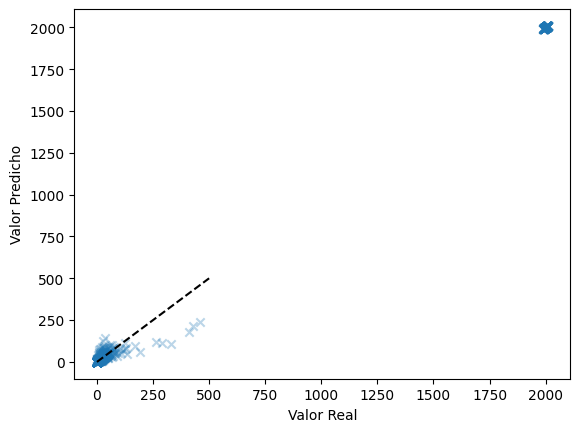

In [123]:
valida(modelo_rf)

Estimación de mejores hiperparámetros con ***RandomSearch***

In [125]:
modelo_rf =RandomForestRegressor()

# Definir rand de parámetros
parametros = {
    'n_estimators': [10, 20, 50],
    'max_depth': [2, 4, 6],
    'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']
}

# Cross Validation
cv = KFold(n_splits=87, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
RS_rf = RandomizedSearchCV(modelo_rf, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
#X_train_div, X_valid, y_train_div, y_valid
RS_rf.fit(X_train_div, y_train_div)

# Obtener mejores parámetros
mejores_params = RS_rf.best_params_
print(mejores_params)

{'n_estimators': 20, 'max_depth': 6, 'criterion': 'poisson'}


Entreno el modelo randomforest con los hiperparámetros obtenidos por random search

In [132]:
modelo_rf_rs = RandomForestRegressor(**mejores_params)
modelo_rf_rs.fit(X_train_div, y_train_div)

RandomForestRegressor(criterion='poisson', max_depth=6, n_estimators=20)

MAPE: 26.23%


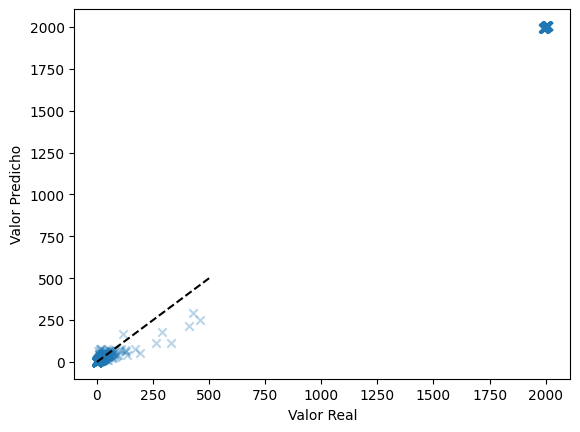

In [133]:
valida(modelo_rf_rs)

Estimación de los mejores hiperparámetros con ***GridSearch***

In [134]:
modelo_rf =RandomForestRegressor()

# Definir rand de parámetros
parametros = {
    'n_estimators': [10, 20, 50],
    'max_depth': [2, 4, 6],
    'criterion': ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']
}

# Cross Validation
cv = KFold(n_splits=87, shuffle=True, random_state=42) # sigo usando el número de splits obtenido anteriormente

# RandomSearch
GS_rf = GridSearchCV(modelo_rf, parametros, cv=cv, n_jobs=-1)

# Entrenar modelo
#X_train_div, X_valid, y_train_div, y_valid
GS_rf.fit(X_train_div, y_train_div)

# Obtener mejores parámetros
mejores_params = GS_rf.best_params_
print(mejores_params)

{'criterion': 'poisson', 'max_depth': 6, 'n_estimators': 10}


Entreno el modelo con ***GridSearch***

In [135]:
modelo_rf_gs = RandomForestRegressor(**mejores_params)
modelo_rf_gs.fit(X_train_div, y_train_div)

RandomForestRegressor(criterion='poisson', max_depth=6, n_estimators=10)

MAPE: 27.11%


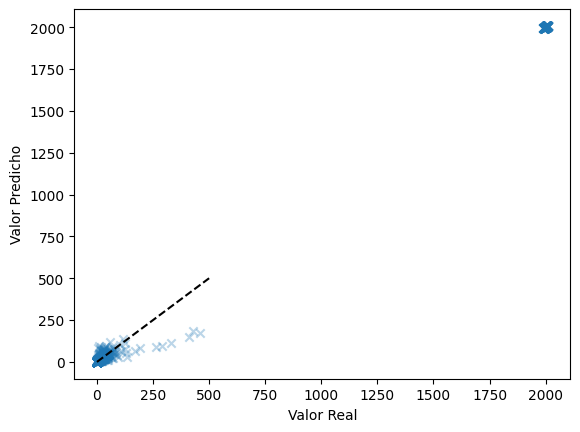

In [137]:
valida(modelo_rf_gs)

In [205]:
modelo_rf_gs.fit(X_train_definitivo, y_train) #entreno el modelo con todos los datos de train

y_pred_def = modelo_rf_gs.predict(X_test_definitivo)
X_resultado =X_test.copy()


salida=pd.DataFrame(y_pred_def,columns=sub_format.columns,index=None)
X_resultado['total_cases'] = salida['total_cases']


#redondeo los resultados
y=np.rint(X_resultado) #redondeo a enteros
y=y.astype(int) #transformo a enteros
y[y<0]=0 #elimino resultados negativos

y

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1,2008,18,0,0,0,0,79,298,299,...,79,79,16,3,27,7,33,22,75,20
1,1,2008,19,0,0,0,0,13,298,299,...,78,13,16,3,26,6,30,22,34,20
2,1,2008,20,0,0,0,0,4,299,299,...,78,4,17,4,28,8,33,23,3,20
3,1,2008,21,0,0,0,0,0,300,300,...,73,0,16,4,28,6,33,24,0,20
4,1,2008,22,0,0,0,0,1,300,300,...,74,1,16,4,28,7,33,23,84,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,2013,22,0,0,0,0,41,298,299,...,90,41,17,10,27,9,33,22,33,20
412,0,2013,23,0,0,0,0,72,297,298,...,94,72,17,10,28,11,34,21,68,20
413,0,2013,24,0,0,0,0,79,296,297,...,95,79,16,7,27,10,33,22,93,20
414,0,2013,25,0,0,0,0,40,296,297,...,89,40,15,8,27,8,32,22,34,25


In [207]:
nombre_fichero="RandomForest_GridSearch"
salida=pd.DataFrame(y,columns=sub_format.columns,index=None)
print(salida)
#columnas_resultado)
salida['city'] = salida['city'].replace({1: 'sj', 0: 'iq'})
# #salida=salida.drop(salida.columns[0],axis=1)
salida.to_csv(nombre_fichero + '.csv',index=False) #guarda el csv con los resultados en el espacio de disco de google colab
files.download(nombre_fichero + '.csv') #descarga al disco duro el fichero de resultados

     city  year  weekofyear  total_cases
0       1  2008          18           20
1       1  2008          19           20
2       1  2008          20           20
3       1  2008          21           20
4       1  2008          22           20
..    ...   ...         ...          ...
411     0  2013          22           20
412     0  2013          23           20
413     0  2013          24           20
414     0  2013          25           25
415     0  2013          26           25

[416 rows x 4 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***Resultado*** de la subida a ***Driven Data*** para ***Random Forest*** con ***Grid Search***

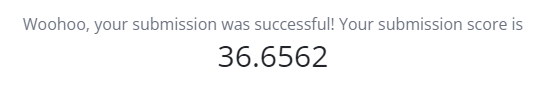